In [1]:
# -*- coding: utf-8 -*-

from __future__ import print_function
import time
from AIToolbox import MDP, POMDP
import itertools
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt
import random

# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

# belief update iterations
iters = 25


# MODEL

MOVE_UP = 0
MOVE_RIGHT = 1
MOVE_DOWN = 2
MOVE_LEFT = 3

Given $s = (\underbar{x}, \theta)$, independently of the actual deformation:

$$T(s,a,s\_) = 1(\underbar{x}\_ = \underbar{x} + a) \cdot (\theta = \theta\_)$$

The reward is given by:
$$R(s,a,s\_) = 
\begin{cases}
\end{cases}$$



In [2]:


class GridEnvDeform(gym.Env):
    def __init__(self, maze):

        self.original_maze = maze
        self.original_maze_shape = maze.shape
 
        self.maze = maze
        self.maze_shape = maze.shape

        # list of possible actions
        self.actions = [0,1,2,3]
        # list of possible orientations
        self.orientations = [0,1,2,3]
        # list of possible observations
        self.obs = list(itertools.product([0,1], repeat=5))
        # list of possible deformations
        self.deformations = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

        # space in which every maze lives (is a 2d matrix)
        self.max_shape = self.original_maze.shape * np.array([h1-1,h0-1]) + np.array([2,2])
        
        self.goal_pos = self.original_maze.shape - np.array([2,2])
        
        self.reset()
        
    def T(self, s, a, s_):
        """ s = [(x, y, phi), thetas]
            T(s,a,s_) transition probability from s to s_ given action a 
            assuming is deterministic and always possible to move in the direction of the action (except at the boundaries)
        """
        # if the maze deformation is different the transition is impossible       
        if s[1] != s_[1]:
            return 0.
                
        return 1. if np.all(self.step(a,s)[0] == s_[0]) else 0

    def O(self, s, a, o):
        # observation probability

        return 1 if np.all(self.get_observation(s) == o) else 0
    
    def R(self, s, a, s_=None):
        
        """R(s,a,s_) reward for getting to s_ (independent from previous state and action taken)"""
            
        return self.step(a,s)[1]            
    
    def step(self, a, s=None, execute=False):

        """take action a from state s (if given) or from actual state of the maze """
        
        if s is not None:
            self.set_deformed_maze(s[1])
            x, y, phi = s[0][:3]
            x_, y_, phi_ = x, y, phi
        else:
            x, y = self.agent_pos
            phi = self.agent_orientation
            x_, y_, phi_ = x, y, phi

        actual_action = (a + phi) % 4
        
        if actual_action == 0:  # Move up
            new_pos = [x - 1, y]
        elif actual_action == 2:  # Move down
            new_pos = [x + 1, y]
        elif actual_action == 3:  # Move left
            new_pos = [x, y - 1]
        elif actual_action == 1:  # Move right
            new_pos = [x, y + 1]
        else:
            raise ValueError("Invalid Action")
        
        # Check if the new position is valid (inside the maze and not a wall)
        if 0 < new_pos[0] < self.max_shape[0]-1 and 0 < new_pos[1] < self.max_shape[1]-1:
            x_, y_ = new_pos
            if execute:
                self.agent_pos = new_pos

        phi_ = (phi + a) % 4
        
        if execute:
            self.agent_orientation = phi_
        
        terminated = np.all((x_,y_) == self.goal_pos)

        if np.all((x_,y_) == self.goal_pos):
            # if the agent is in the goal position
            reward =  1            
        elif np.all((x_,y_) == (x,y)):
            # if the agent has not moved (only at the boundary of the maze)
            reward =  -100/(self.max_shape[0]*self.max_shape[1])
        elif self.maze[x_, y_] == 1:
            # if the agent has entered a wall
            reward =  -100/(self.max_shape[0]*self.max_shape[1])
        elif self.maze[x_, y_] == 0:
            # if the agent has moved to a free cell
            reward =  -1/(self.max_shape[0]*self.max_shape[1])

        info = {}
        truncated = False 

        s_ = np.array([x_, y_, phi_])
        
        
        return s_, reward, terminated, info, truncated
    
    def get_observation(self, s):

        self.set_deformed_maze(s[1])

        agent_pos = s[0][:2]
        agent_orientation = s[0][2]
        ind = [agent_pos + a for a in [np.array([0,-1]),
                                            np.array([-1,-1]),
                                            np.array([-1,0]),
                                            np.array([-1,+1]),
                                            np.array([0,+1]),
                                            np.array([+1,+1]),
                                            np.array([+1,0]),
                                            np.array([+1,-1])]]

        agent_obs = np.array([self.maze[tuple(ind[i%8])] 
                                                for i in range(2*agent_orientation, 2*agent_orientation+5)])


        return agent_obs
    
    def set_deformed_maze(self,thetas: tuple):
        self.maze = self.stretch_maze(thetas)
        self.goal_pos = self.maze.shape - np.array([thetas[1],thetas[0]])
        
        canva1 = np.ones(self.max_shape, dtype=int)  # Start with walls
        # Place the original maze in the canvas
        canva1[1:self.maze.shape[0] + 1, 1:self.maze.shape[1] + 1] = self.maze

        self.maze = canva1
   
    def stretch_maze(self, thetas):
        scale_x, scale_y = thetas
        maze = self.original_maze

        original_height, original_width = maze.shape
        # Calculate new dimensions
        new_height = original_height * scale_y
        new_width = original_width * scale_x
        
        # Create a new maze with stretched dimensions
        stretched_maze = np.ones((new_height, new_width), dtype=int)

        # Fill the new maze with values from the original maze
        for i in range(original_height):
            for j in range(original_width):
                if maze[i, j] == 0:  # Path cell
                    # Fill the corresponding region in the stretched maze
                    stretched_maze[i*scale_y:(i+1)*scale_y, j*scale_x:(j+1)*scale_x] = 0

        return stretched_maze
    
    def set_state(self, s):
        theta0, theta1 = s[1][1], s[1][0]
        self.agent_pos = np.array(s[0][:2]) # + np.array([1,1]) * np.array((theta0,theta1))
        self.agent_orientation = s[0][2]
        self.set_deformed_maze(s[1])
    
    def get_state(self):
        return (self.agent_pos[0],self.agent_pos[1], self.agent_orientation), (self.maze.shape[0], self.maze.shape[1])
    
    def render(self, s=None, s_prime=None):
        """
        belief will be always distributed as follows 
        there exist a tuple (x_0,y_0,phi_0) such that
        for the two possible deformations theta0 theta1

        b((x_0,y_0,phi_0), theta_0) = b((x_0,y_0,phi_0), theta_1) = 0.5
        and 
        b = 0 everywere else
        
        rendering will show the same position in the two different possibile maze deformations
        along with the probability of each status
        """
        if s is not None:
            self.set_state(s)
        
        maze_render = np.copy(self.maze)
        maze_render[tuple(self.agent_pos)] = 2  # Show agent position
        maze_render[tuple(self.goal_pos)] = 4  # Show goal position
        plt.imshow(maze_render, cmap='binary', origin='upper')
        plt.show()

    def reset(self, seed=42):
        randomdeformation = random.choice(self.deformations)
        self.agent_pos = [1,1] + np.array([1,1]) * np.array((randomdeformation[1],randomdeformation[0]))
        self.agent_orientation = 0
        self.set_deformed_maze(randomdeformation)
        return (self.agent_pos[0],self.agent_pos[1], self.agent_orientation), (self.maze.shape[0], self.maze.shape[1])
        
def create_maze(dim):
    maze = np.ones((dim*2+1, dim*2+1))
    x, y = (0, 0)
    maze[2*x+1, 2*y+1] = 0
    stack = [(x, y)]
    
    while len(stack) > 0:
        x, y = stack[-1]
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < dim and ny < dim and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    # Create entrance and exit
    # maze[1, 0] = 0
    # maze[-2, -1] = 0

    return maze

def stretch_maze(maze, scale_x, scale_y):
    original_height, original_width = maze.shape
    # Calculate new dimensions
    new_height = original_height * scale_y
    new_width = original_width * scale_x
    
    # Create a new maze with stretched dimensions
    stretched_maze = np.ones((new_height, new_width), dtype=int)

    # Fill the new maze with values from the original maze
    for i in range(original_height):
        for j in range(original_width):
            if maze[i, j] == 0:  # Path cell
                # Fill the corresponding region in the stretched maze
                stretched_maze[i*scale_y:(i+1)*scale_y, j*scale_x:(j+1)*scale_x] = 0

    return stretched_maze



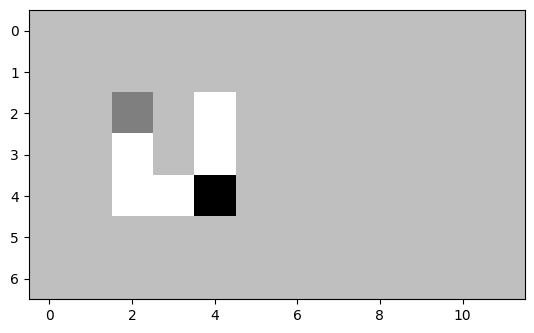

In [4]:
maze = create_maze(N)
env = GridEnvDeform(maze)
env.render()

In [5]:

# s = [(x, y, phi), thetas]
states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
observations = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

# Actions are: 0-listen, 1-open-left, 2-open-right
S = len(states)
A = len(actions)
O = len(observations)

print(f"States: {S}, Actions: {A}, Observations {O}, Thetas {thetas}\n")

model = POMDP.Model(O, S, A)


print("setting reward function\n")
rewards = [[[env.R(s,a) for s_ in states ]for a in actions] for s in states]
model.setRewardFunction(rewards)

print("setting transition function\n")
transitions = [[[env.T(s,a,s_) for s_ in states] for a in actions] for s in states]
model.setTransitionFunction(transitions)

print("setting observation function\n")
observations = [[[env.O(s,a,o) for o in observations] for a in actions] for s in states]
model.setObservationFunction(observations)

print("transition probability shape: ", np.array(transitions).shape)
print("reward shape: ", np.array(rewards).shape)
print("observation shape: ", np.array(observations).shape)



States: 400, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]
setting reward function

setting transition function

setting observation function

transition probability shape:  (400, 4, 400)
reward shape:  (400, 4, 400)
observation shape:  (400, 4, 32)


In [22]:
model.setDiscount(0.99)
# Set the horizon. This will determine the optimality of the policy
# dependent on how many steps of observation/action we plan to do.
horizon = 30
# Perseus arguments: belief points horizon tolerance
solver_sarsop = POMDP.PERSEUS(1000,horizon, 0.0)

# Solve the model. After this line, the problem has been completely
# solved. All that remains is setting up an experiment and see what
# happens!

# perseous solver model and min reward
solution_sarsop = solver_sarsop(model, -2)

# We create a policy from the solution_sarsop, in order to obtain actual actions
# depending on what happens in the environment.
policy = POMDP.Policy(S, A, O, solution_sarsop[1])



In [23]:
# uniform belief state
b_unif = list(np.ones(len(states)) / len(states))

# random belief state
b_rand = np.random.rand(len(states))
b_rand = list(b_rand / np.sum(b_rand))

# realistic belief state
b_0 = [0] * len(states)
b_0[states.index(((1,1,0),(1,1)))] = 0.5
b_0[states.index(((1,1,0),(2,1)))] = 0.5


((5, 5, 1), (2, 1))


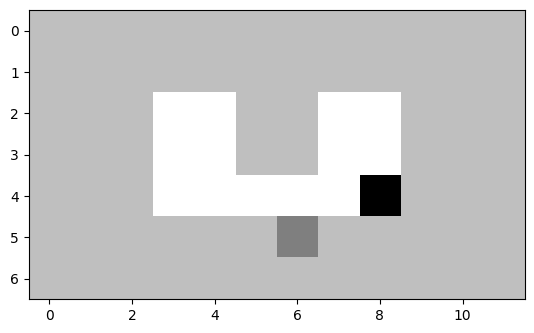

Timestep missing: 29  
Total reward:     -1.1904761904761905  
max and argmax Belief:  ((1, 4, 3), (2, 1)) 0.049999999999999996


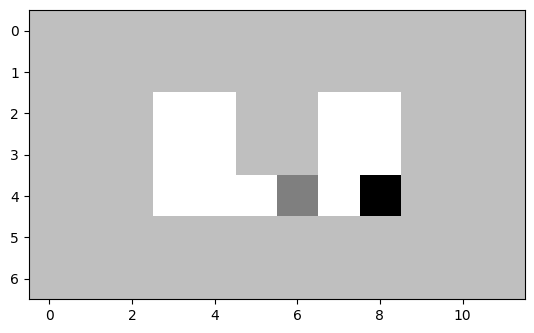

Timestep missing: 28  
Total reward:     -1.2023809523809523  
max and argmax Belief:  ((3, 2, 1), (1, 1)) 0.5


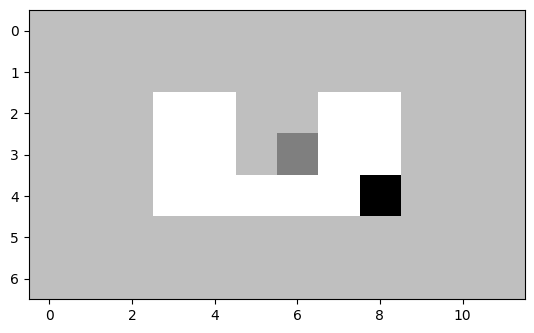

Timestep missing: 27  
Total reward:     -2.392857142857143  
max and argmax Belief:  ((3, 6, 0), (2, 1)) 1.0


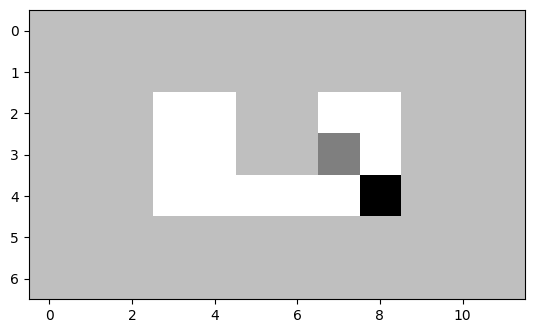

Timestep missing: 26  
Total reward:     -2.4047619047619047  
max and argmax Belief:  ((3, 7, 1), (2, 1)) 1.0


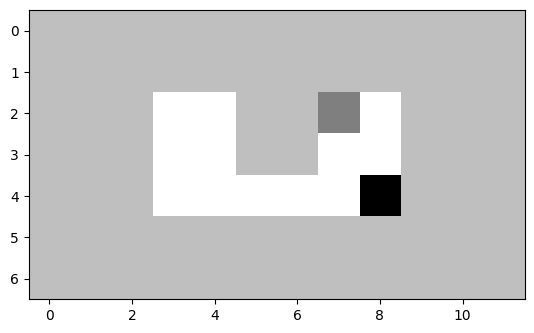

Timestep missing: 25  
Total reward:     -2.4166666666666665  
max and argmax Belief:  ((2, 7, 0), (2, 1)) 1.0


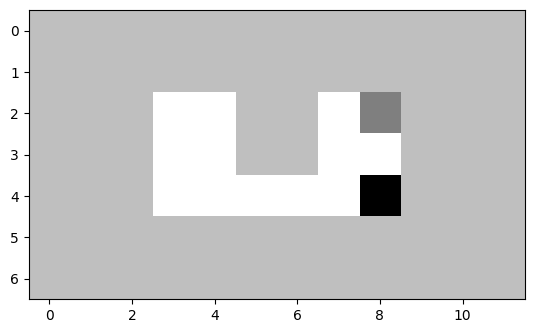

Timestep missing: 24  
Total reward:     -2.4285714285714284  
max and argmax Belief:  ((2, 8, 1), (2, 1)) 1.0


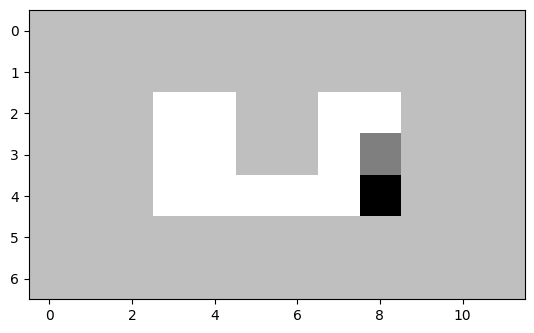

Timestep missing: 23  
Total reward:     -2.4404761904761902  
max and argmax Belief:  ((3, 8, 2), (2, 1)) 1.0


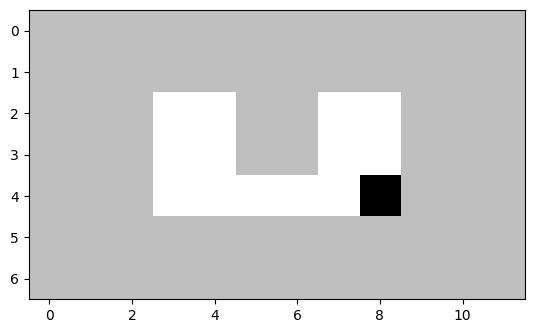

Timestep missing: 22  
Total reward:     -1.4404761904761902  
max and argmax Belief:  ((4, 8, 2), (2, 1)) 1.0


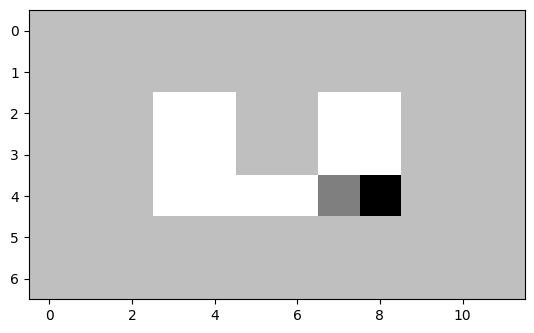

Timestep missing: 21  
Total reward:     -1.452380952380952  
max and argmax Belief:  ((4, 7, 3), (2, 1)) 1.0


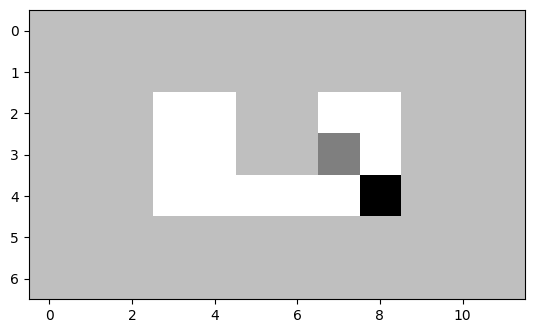

Timestep missing: 20  
Total reward:     -1.464285714285714  
max and argmax Belief:  ((3, 7, 0), (2, 1)) 1.0


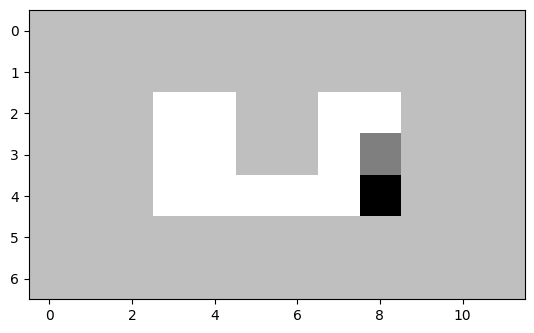

Timestep missing: 19  
Total reward:     -1.4761904761904758  
max and argmax Belief:  ((3, 8, 1), (2, 1)) 1.0


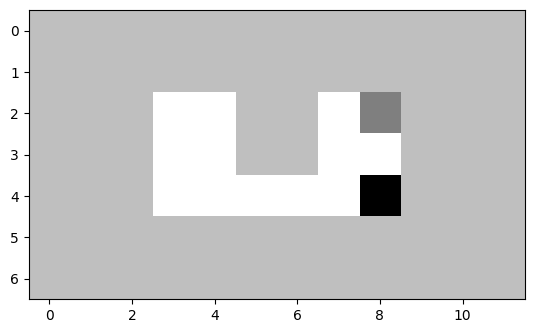

Timestep missing: 18  
Total reward:     -1.4880952380952377  
max and argmax Belief:  ((2, 8, 0), (2, 1)) 1.0


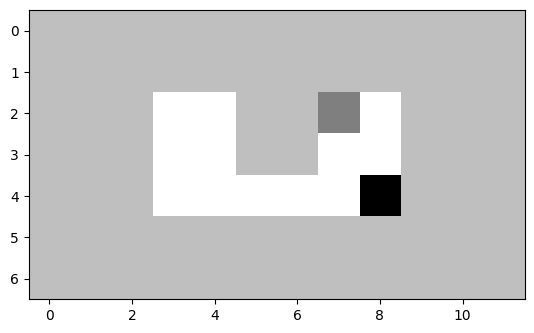

Timestep missing: 17  
Total reward:     -1.4999999999999996  
max and argmax Belief:  ((2, 7, 3), (2, 1)) 1.0


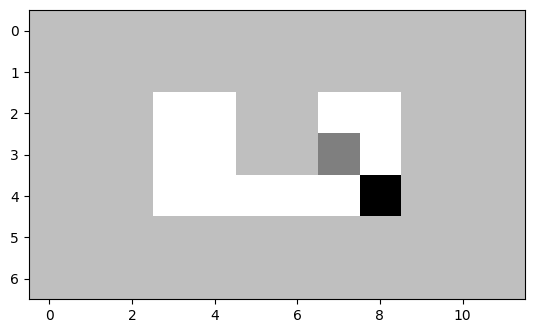

Timestep missing: 16  
Total reward:     -1.5119047619047614  
max and argmax Belief:  ((3, 7, 2), (2, 1)) 1.0


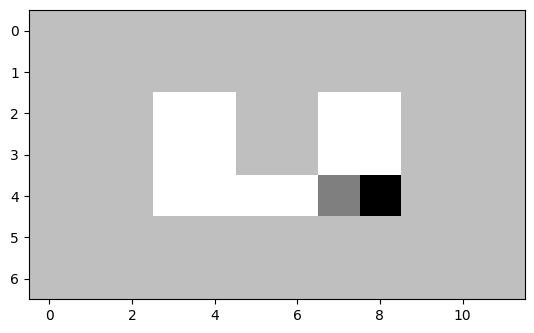

Timestep missing: 15  
Total reward:     -1.5238095238095233  
max and argmax Belief:  ((4, 7, 2), (2, 1)) 1.0


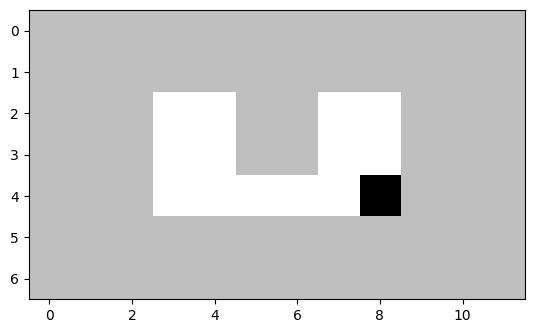

Timestep missing: 14  
Total reward:     -0.5238095238095233  
max and argmax Belief:  ((4, 8, 1), (2, 1)) 1.0


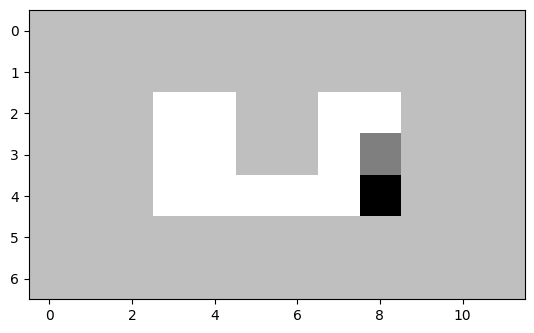

Timestep missing: 13  
Total reward:     -0.5357142857142851  
max and argmax Belief:  ((3, 8, 0), (2, 1)) 1.0


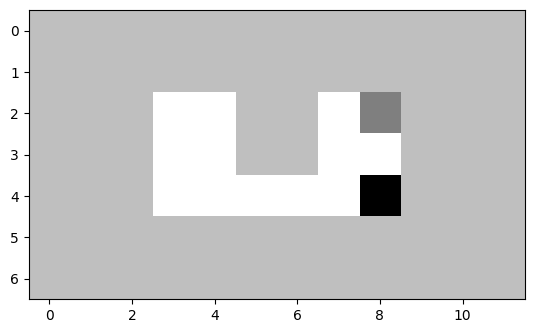

Timestep missing: 12  
Total reward:     -0.547619047619047  
max and argmax Belief:  ((2, 8, 0), (2, 1)) 1.0


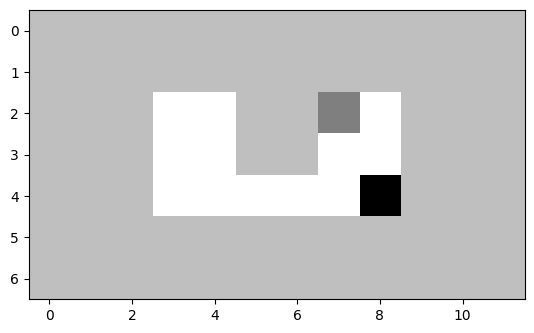

Timestep missing: 11  
Total reward:     -0.5595238095238089  
max and argmax Belief:  ((2, 7, 3), (2, 1)) 1.0


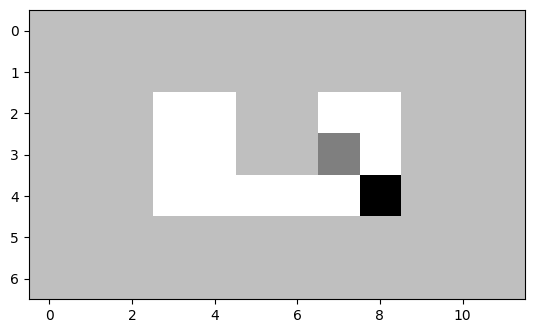

Timestep missing: 10  
Total reward:     -0.5714285714285707  
max and argmax Belief:  ((3, 7, 2), (2, 1)) 1.0


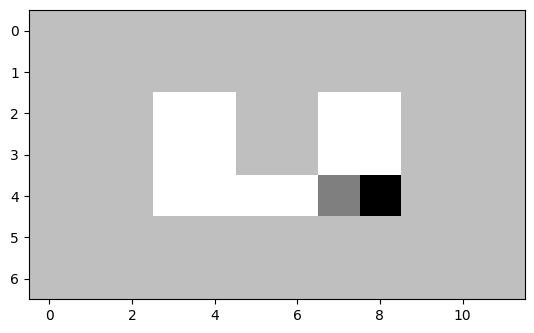

Timestep missing: 9  
Total reward:     -0.5833333333333326  
max and argmax Belief:  ((4, 7, 2), (2, 1)) 1.0


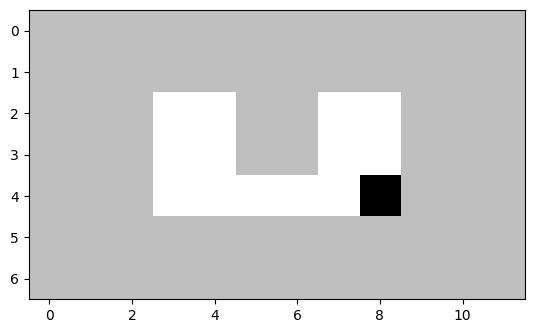

Timestep missing: 8  
Total reward:     0.4166666666666674  
max and argmax Belief:  ((4, 8, 1), (2, 1)) 1.0


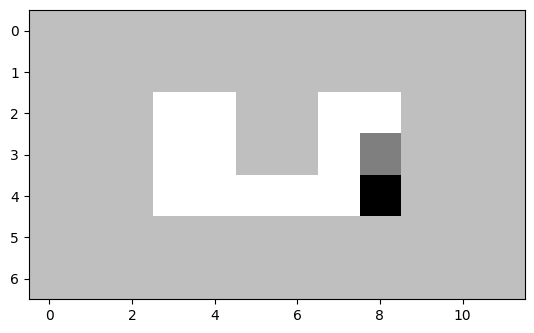

Timestep missing: 7  
Total reward:     0.4047619047619055  
max and argmax Belief:  ((3, 8, 0), (2, 1)) 1.0


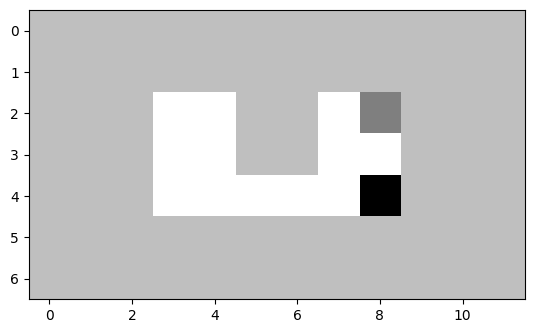

Timestep missing: 6  
Total reward:     0.39285714285714357  
max and argmax Belief:  ((2, 8, 0), (2, 1)) 1.0


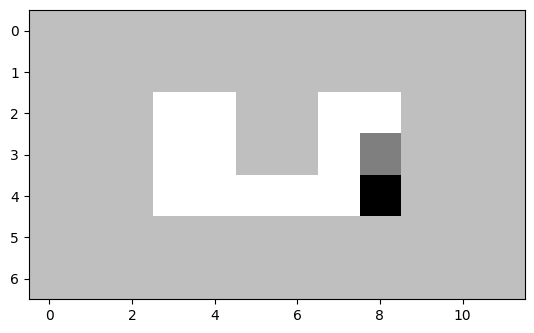

Timestep missing: 5  
Total reward:     0.38095238095238165  
max and argmax Belief:  ((3, 8, 2), (2, 1)) 1.0


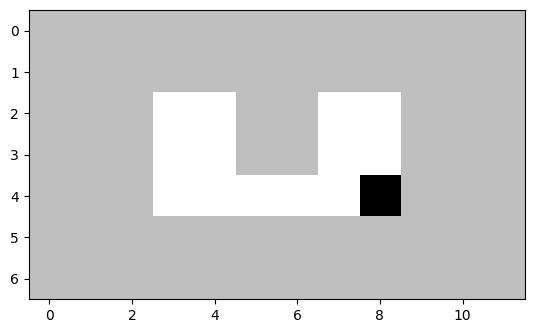

Timestep missing: 4  
Total reward:     1.3809523809523816  
max and argmax Belief:  ((4, 8, 2), (2, 1)) 1.0


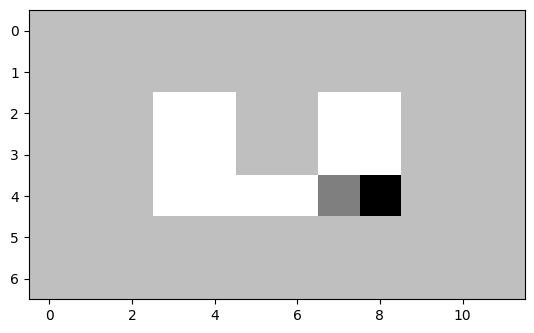

Timestep missing: 3  
Total reward:     1.3690476190476197  
max and argmax Belief:  ((4, 7, 3), (2, 1)) 1.0


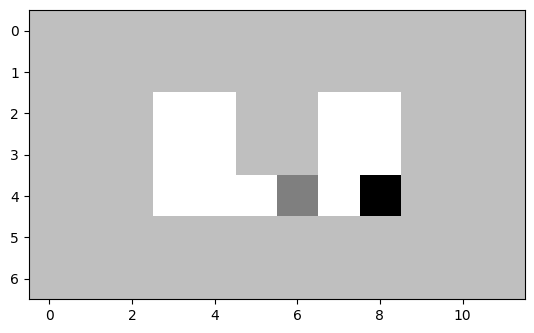

Timestep missing: 2  
Total reward:     1.3571428571428579  
max and argmax Belief:  ((4, 6, 3), (2, 1)) 1.0


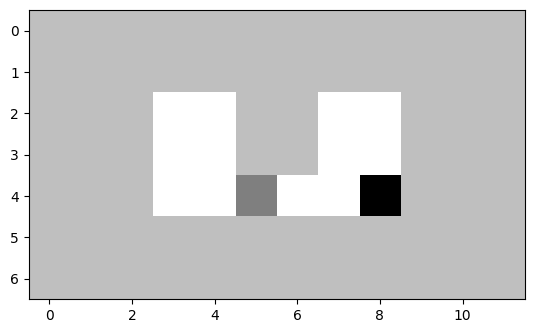

Timestep missing: 1  
Total reward:     1.345238095238096  
max and argmax Belief:  ((4, 5, 3), (2, 1)) 1.0


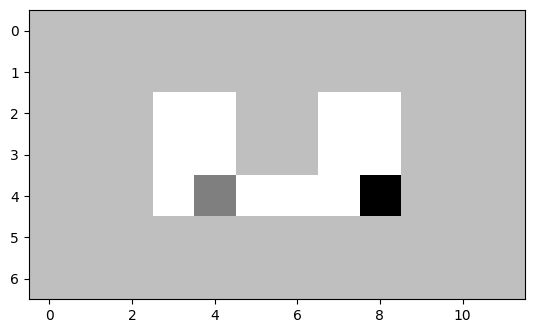

Timestep missing: 0  
Total reward:     1.3333333333333341  
max and argmax Belief:  ((4, 4, 3), (2, 1)) 1.0


In [42]:
# the simulation starts with given belief and random state
b = b_unif
s = np.random.randint(len(states))

print("Initial state: ", states[s])
env.render(states[s])


# The first thing that happens is that we take an action, so we sample it now.
a, ID = policy.sampleAction(b, horizon)

# We loop for each step we have yet to do.
totalReward = 0.0
for t in range(horizon - 1, -1, -1):
    # We advance the world one step (the agent only sees the observation
    # and reward).
    s1, o, r = model.sampleSOR(s, a)
    # We update our total reward.
    totalReward += r

    # Rendering of the environment (the actual state)
    env.render(states[s1])

    print("Timestep missing: " + str(t) + "  ") # Print space after to clear
    print("Total reward:     " + str(totalReward) + "  ")

    # We explicitly update the belief to show the user what the agent is
    # thinking. 
    b = POMDP.updateBelief(model, b, a, o)
    print("max and argmax Belief: ", states[np.argmax(b)], np.max(b))

    # Now that we have rendered, we can use the observation to find out
    # what action we should do next.
    #
    # Depending on whether the solution converged or not, we have to use
    # the policy differently. Suppose that we planned for an horizon of 5,
    # but the solution converged after 3. Then the policy will only be
    # usable with horizons of 3 or less. For higher horizons, the highest
    # step of the policy suffices (since it converged), but it will need a
    # manual belief update to know what to do.
    #
    # Otherwise, the policy implicitly tracks the belief via the id it
    # returned from the last sampling, without the need for a belief
    # update. This is a consequence of the fact that POMDP policies are
    # computed from a piecewise linear and convex value function, so
    # ranges of similar beliefs actually result in needing to do the same
    # thing (since they are similar enough for the timesteps considered).
    if t > policy.getH():
        a, ID = policy.sampleAction(b, policy.getH())
    else:
        a, ID = policy.sampleAction(ID, o, t)

    # Then we update the world
    s = s1

    # Sleep 1 second so the user can see what is happening.
    time.sleep(1)

# Put the cursor back where it should be.

In [28]:
states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
states[s]

((1, 1, 1), (1, 1))